# Importing and Configs

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

from gym import error, spaces, utils
from gym.utils import seeding
from tabulate import tabulate
from enum import Enum
from copy import copy, deepcopy
from random import randint, random, choice
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from operator import add
from tqdm import tqdm
from IPython.display import display, clear_output

# Definig Environments

## objects in environment

In [2]:
class WorldObj:
    def __init__(self, name):
        self.name = name
        
    def __repr__(self):
        return " "
    
class Empty(WorldObj):
    def __init__(self):
        super().__init__('empty')
    
class Log(WorldObj):
    def __init__(self):
        super().__init__('log')
    
    def __repr__(self):
        return '_'
    
class Gold(WorldObj):
    def __init__(self):
        super().__init__('gold')
    
    def __repr__(self):
        return 'G'
    
class Food(WorldObj):
    def __init__(self):
        super().__init__('food')
    
    def __repr__(self):
        return '8'
    
    
class Trap(WorldObj):
    def __init__(self):
        super().__init__('trap')
        self.state = None
    
    def __repr__(self):
        return 'X'

class Teleport(WorldObj):
    def __init__(self, dest, chance=0.8):
        super().__init__('teleport')
        self.destination = dest
        self.chance = chance
    
    def __repr__(self):
        return 'T'
    
    
class Stream(WorldObj):
    """
    stream only goes down or right!
    """
    
    def __init__(self, _dir: int):
        super().__init__('stream')
        self.dir = _dir
    
    def __repr__(self):
        return '~'
    
class Miner(WorldObj):
    def __init__(self):
        super().__init__('miner')
    
    def __repr__(self):
        return '*'
        

## Defining Envrionment

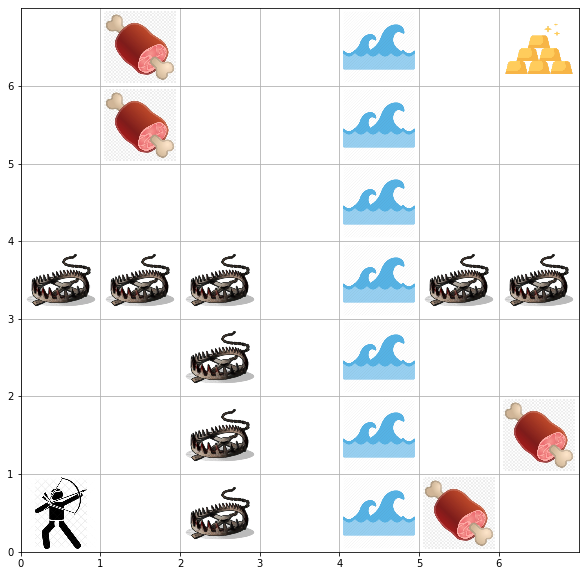

In [10]:
class Action(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    LOG_RIGHT = 4
    LOG_DOWN = 5
    LOG_LEFT = 6
    LOG_UP = 7
    
    

class GoldHuntEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    static_map_size = 7
    movement_acts = [Action.RIGHT, Action.LEFT, Action.DOWN, Action.UP,]
    craft_acts = [Action.LOG_RIGHT, Action.LOG_LEFT, Action.LOG_DOWN, Action.LOG_UP,]

    def __init__(self, ascii_rep=True):
        self.ascii_rep = ascii_rep
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(49)
        self.info = {}
        self.max_time_step = 50 
        self.food_reward = 5
        self.gold_reward = 10
        self.trap_falling_reward = -5
        self.craft_log_reward = -3
        self.gold_loc = [6, 6]
        self.food_prob = 0.6
        
    def generate_static_map(self, agent_pos):
        env_map = [[Empty() for _ in range(self.map_size)] for _ in range(self.map_size)]
        
        env_map[2][0] = Trap()
        env_map[2][1] = Trap()
        env_map[2][2] = Trap()
        env_map[2][3] = Trap()
        env_map[1][3] = Trap()
        env_map[0][3] = Trap()
        env_map[5][3] = Trap()
        env_map[6][3] = Trap()
        
        
#         env_map[6][0] = Teleport(dest=[0, 6])
        env_map[self.gold_loc[0]][self.gold_loc[1]] = Gold()
        
        env_map[4][0] = Stream(_dir=Action.LEFT.value)
        env_map[4][1] = Stream(_dir=Action.LEFT.value)
        env_map[4][2] = Stream(_dir=Action.LEFT.value)
        env_map[4][3] = Stream(_dir=Action.LEFT.value)
        env_map[4][4] = Stream(_dir=Action.LEFT.value)
        env_map[4][5] = Stream(_dir=Action.LEFT.value)
        env_map[4][6] = Stream(_dir=Action.LEFT.value)
        
            
        return env_map

    def get_pos_obj(self, pos):
        return self.env_map[pos[0]][pos[1]]

    def stochastic_generation(self, pos, obj, prob):
        if random() < prob:
            self.env_map[pos[0]][pos[1]] = obj
    
    def _get_next_pos(self, current_loc, action):
        action_dir = Action(action)
        next_pos = copy(current_loc)
        
        if action_dir not in self.movement_acts:
            return current_loc
        
        if action_dir == Action.RIGHT:
            next_pos[1] = self._restricted_move(next_pos[1], 1)
        elif action_dir == Action.LEFT:
            next_pos[1] = self._restricted_move(next_pos[1], -1)
        elif action_dir == Action.UP:
            next_pos[0] = self._restricted_move(next_pos[0], -1)
        elif action_dir == Action.DOWN:
            next_pos[0] = self._restricted_move(next_pos[0], 1)
            
        return next_pos
        
        
    def _restricted_move(self, init_val, res):
        new_val = init_val + res
        if new_val >= self.map_size:
            new_val = self.map_size - 1
        elif new_val < 0:
            new_val = 0
        return new_val
    
    
    def pos_to_state(self, pos):
        return pos[0]*self.map_size + pos[1]
    
    def on_border(self, pos):
        if pos[0] == 0 or pos[0] == self.map_size-1 or pos[1] == 0 or pos[1] == self.map_size-1:
            return True
        return False
    
    
    def craft_log(self, current_pos, action: int):
        """
        returns True if log is crafted, False otherwise
        """
        log_loc = self._get_next_pos(current_pos, action-4)
        if log_loc == current_pos or log_loc == self.gold_loc:
            return False
        
        self.agent_pos = log_loc
        self.env_map[log_loc[0]][log_loc[1]] = Log()
        return True
    
    def generate_stochastic_elements(self):
        self.stochastic_generation([1,6], Food(), self.food_prob)
        self.stochastic_generation([0,5], Food(), self.food_prob)
        self.stochastic_generation([1,5], Food(), self.food_prob)
        self.stochastic_generation([5,1], Food(), self.food_prob)
        self.stochastic_generation([5,0], Food(), self.food_prob)
        self.stochastic_generation([6,1], Food(), self.food_prob)
    
    def step(self, action: int):
        self.info['statu'] = ""
        self.info['step'] = self.time_step
        self.time_step += 1
        
        done = self.time_step > self.max_time_step 
        reward = -1
        
        self.info['action'] = f"agent performed {Action(action)}"
        curr_obj = self.get_pos_obj(self.agent_pos)
        
        # agent was trapped before
        if isinstance(curr_obj, Trap) and Action(action) in self.movement_acts:
            # this part shows that trap needs memory 
            #             trap_state = curr_obj.state
#             if trap_state is None or action != (trap_state+2)%4:
#                 self.info['status'] = f"Agent in trap with previous action of {None if curr_obj.state is None else Action(curr_obj.state)}"
#                 curr_obj.state = action
#                 self.info['cum_r'] += reward
#                 return self.pos_to_state(self.agent_pos), reward, done, self.info
#             else:
#                 self.info['status'] = f"Agent broke the trap"
#                 self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()
            self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()        
        
        # agent crafts a log
        if Action(action) in self.craft_acts:
            is_crafted = self.craft_log(self.agent_pos, action)
            
            if is_crafted:
                self.info['status'] = 'agent crafted a log'
                reward = self.craft_log_reward
            
            self.info['cum_r'] += reward
            return self.pos_to_state(self.agent_pos), reward, done, self.info
        

        next_pos = self._get_next_pos(self.agent_pos, action)
        next_obj = self.get_pos_obj(next_pos)

        # stream takes agent when he falls into it
        if isinstance(next_obj, Stream):
            self.info['status'] = ('agent fell into a stream')
            while isinstance(next_obj, Stream):
                next_pos = self._get_next_pos(next_pos, next_obj.dir)
                next_obj = self.get_pos_obj(next_pos)
                
                if isinstance(next_obj, Stream) and self.on_border(next_pos):
                    if next_pos[0] == self.map_size-1 and next_pos[1] == self.map_size-1:
                        done = True
                        reward = -20
                    elif next_pos[0] == self.map_size-1 and Action(next_obj.dir) == Action.DOWN:
                        next_pos[1] = self._restricted_move(next_pos[1], 1)
                    elif next_pos[0] == 0 and Action(next_obj.dir) == Action.UP:
                        next_pos[1] = self._restricted_move(next_pos[1], -1)
                    elif next_pos[1] == self.map_size-1 and Action(next_obj.dir) == Action.RIGHT:
                        next_pos[0] = self._restricted_move(next_pos[0], 1)
                    elif next_pos[1] == 0 and Action(next_obj.dir) == Action.LEFT:
                        next_pos[0] = self._restricted_move(next_pos[0], -1)
                    
                next_obj = self.get_pos_obj(next_pos)                              
        
        # gets hurt by falling into trap
        if isinstance(next_obj, Trap):
            self.info['status'] = 'agent fell into a trap'
            reward = self.trap_falling_reward
            
        if isinstance(next_obj, Teleport):
            """ manually non deterministic setup for this env """
            
            if random() <= next_obj.chance:
                self.info['status'] = f'agent teleported to {next_obj.destination} '
                self.agent_pos = next_obj.destination
                self._clear_pos(next_obj.destination)
                return self.pos_to_state(self.agent_pos), reward, done, self.info
        
        # refills energy by eating food
        if isinstance(next_obj, Food):
            self.info['status'] = 'agent ate food!'
            self._clear_pos(next_pos)
            reward = self.food_reward
        
        # agent finds the gold
        if isinstance(next_obj, Gold):
            self.info['status'] = 'agent found the GOLD!'
            done = True
            reward = self.gold_reward
            
        self.agent_pos = next_pos
        self.info['cum_r'] += reward
        
        return self.pos_to_state(self.agent_pos), reward, done, self.info

    def _clear_pos(self, pos):
        self.env_map[pos[0]][pos[1]] = Empty()
    
    def reset(self):
        self.info = {
            'cum_r': 0,
            'action': "",
            'status': "",
            'step': 0
        }
        
        self.map_size = self.static_map_size
        self.agent_pos = [0, 0]
        self.env_map = self.generate_static_map(self.agent_pos)    
        self.generate_stochastic_elements()
        self.prev_action = None
        self.time_step = 0
        
        return self.pos_to_state(self.agent_pos)
  
    def get_env_rep(self):
        env_map_top_layer = deepcopy(self.env_map)
        env_map_top_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        return tabulate(env_map_top_layer, headers=[], tablefmt='grid')

    def get_rgb_rep(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, self.map_size)
        ax.set_ylim(0, self.map_size)
        
        show_layer = deepcopy(self.env_map)
        show_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        for i in range(len(show_layer)):
            for j in range(len(show_layer)):
                obj = show_layer[i][j]
                
                if isinstance(obj, Gold):
                    path = './images/gold.png'
                elif isinstance(obj, Trap):
                    path = './images/trap.png'
                elif isinstance(obj, Food):
                    path = './images/food.png'
                elif isinstance(obj, Log):
                    path = './images/log.png'
                elif isinstance(obj, Stream):
                    path = './images/stream.png'
                elif isinstance(obj, Teleport):
                    path = './images/teleport.png'
                elif isinstance(obj, Miner):
                    path = './images/agent.png'
                else:
                    continue
                    
                
                obj_repr = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.28),
                       list(map(add, [i, j], [0.5, 0.5])), frameon=False)
                ax.add_artist(obj_repr)
        
        plt.xticks([i for i in range(self.map_size)])
        plt.yticks([i for i in range(self.map_size)])
        plt.grid()
        plt.show()
        
    
    def render(self, mode='human'):
        if self.ascii_rep:
            print(self.get_env_rep())
        else:
            self.get_rgb_rep()
        

    def close(self):
        pass
    
env = GoldHuntEnv(ascii_rep=False)
env.reset()
env.render()

## Manually Playing in Environment

{'cum_r': -13, 'action': 'agent performed Action.DOWN', 'status': 'agent crafted a log', 'step': 6, 'statu': ''}


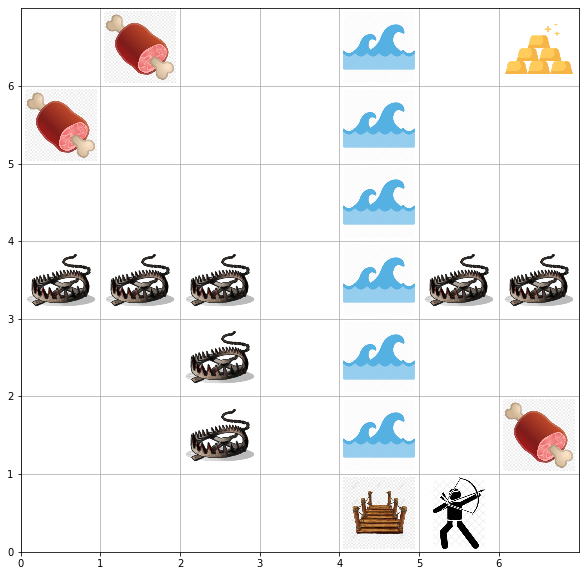

KeyboardInterrupt: Interrupted by user

In [13]:
def play_in_env(env):
    done = False
    clear_output(wait=True)
    env.render()

    while not done:
        action = int(input())
        
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
env = GoldHuntEnv(ascii_rep=False)
env.reset()
play_in_env(env)

## Random agent playing

In [ ]:

def random_agent_play(env, max_steps=10):
    done = False
    clear_output(wait=True)
    env.render()
    step = 0
    
    while not done and step < max_steps:
        
        action = randint(0, 4)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.8)
        step += 1
        
        
env = GoldHuntEnv(ascii_rep=False)
env.reset()
random_agent_play(env, max_steps=50)

## Q-learning Agent

  0%|          | 0/100000 [00:00<?, ?it/s]

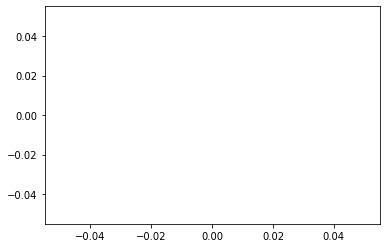

  0%|          | 42/100000 [00:00<12:51, 129.54it/s]

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+



 10%|▉         | 9995/100000 [00:14<01:56, 769.34it/s]

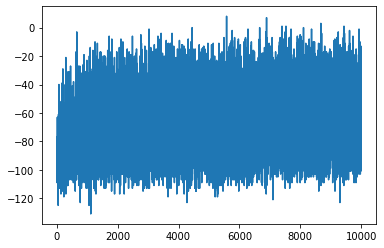

 10%|█         | 10145/100000 [00:14<03:05, 485.41it/s]

+----------+----------+----------+----------+-----------+-----------+-----------+
| -26.7324 | -26.6247 | -26.0049 | -23.3422 | -20.4023  | -19.4295  | -18.7131  |
+----------+----------+----------+----------+-----------+-----------+-----------+
| -27.0635 | -27.1532 | -26.3772 | -24.0528 | -21.4007  | -19.7351  | -19.1011  |
+----------+----------+----------+----------+-----------+-----------+-----------+
| -25.6915 | -26.0568 | -25.3284 | -23.5081 | -21.4718  | -19.5103  | -18.3644  |
+----------+----------+----------+----------+-----------+-----------+-----------+
| -23.9207 | -23.9607 | -23.2745 | -22.0176 | -20.1884  | -18.4549  | -16.9738  |
+----------+----------+----------+----------+-----------+-----------+-----------+
| -20.4728 | -21.0717 | -20.2734 | -19.069  | -16.6013  | -13.9932  | -10.9764  |
+----------+----------+----------+----------+-----------+-----------+-----------+
| -19.0416 | -19.1485 | -18.8047 | -16.3325 | -12.6584  |  -7.43694 |  -3.17592 |
+----------+----

 20%|█▉        | 19949/100000 [00:28<01:49, 728.24it/s]

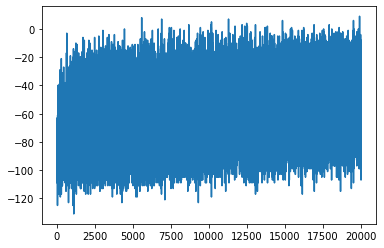

 20%|██        | 20086/100000 [00:28<03:11, 416.53it/s]

+----------+----------+----------+----------+----------+------------+-----------+
| -25.469  | -25.3222 | -24.1509 | -21.7038 | -18.5142 | -17.3881   | -17.2244  |
+----------+----------+----------+----------+----------+------------+-----------+
| -26.2673 | -26.2763 | -25.5495 | -22.7887 | -19.5101 | -17.6282   | -16.9542  |
+----------+----------+----------+----------+----------+------------+-----------+
| -25.3366 | -25.9759 | -25.5309 | -23.3165 | -20.4681 | -17.4636   | -15.8101  |
+----------+----------+----------+----------+----------+------------+-----------+
| -22.96   | -23.4466 | -23.3458 | -22.0344 | -19.6902 | -16.504    | -13.7828  |
+----------+----------+----------+----------+----------+------------+-----------+
| -19.1021 | -20.0592 | -20.4228 | -19.3697 | -15.9779 | -11.7287   |  -8.48813 |
+----------+----------+----------+----------+----------+------------+-----------+
| -17.3636 | -17.4885 | -17.2759 | -15.1746 | -10.7234 |  -5.43553  |  -1.52156 |
+----------+----

 30%|██▉       | 29945/100000 [00:41<01:26, 811.58it/s]

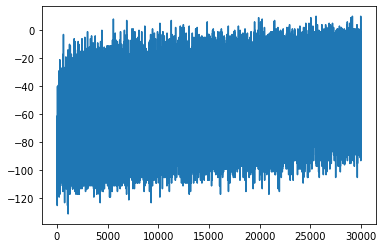

 30%|███       | 30108/100000 [00:42<02:26, 477.00it/s]

+----------+----------+----------+-----------+-----------+-----------+-----------+
| -21.8595 | -21.6369 | -20.4677 | -18.0464  | -14.5138  | -13.4149  | -13.3632  |
+----------+----------+----------+-----------+-----------+-----------+-----------+
| -22.7296 | -22.936  | -22.1716 | -19.2806  | -15.9156  | -13.9696  | -13.1828  |
+----------+----------+----------+-----------+-----------+-----------+-----------+
| -22.0441 | -22.9451 | -22.5566 | -20.4015  | -16.7415  | -14.0905  | -12.4128  |
+----------+----------+----------+-----------+-----------+-----------+-----------+
| -19.399  | -20.1646 | -20.4551 | -19.6089  | -16.2768  | -13.3173  | -10.7526  |
+----------+----------+----------+-----------+-----------+-----------+-----------+
| -15.3986 | -16.4575 | -18.1738 | -17.5121  | -13.0677  |  -8.89519 |  -5.91601 |
+----------+----------+----------+-----------+-----------+-----------+-----------+
| -13.8991 | -13.9127 | -14.1002 | -11.9704  |  -7.83723 |  -2.92026 |   1.2862  |
+---

 40%|███▉      | 39934/100000 [00:56<01:07, 889.81it/s]

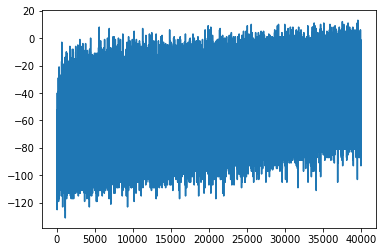

 40%|████      | 40196/100000 [00:57<01:43, 580.06it/s]

+----------+----------+-----------+-----------+-----------+------------+-----------+
| -18.2183 | -17.8059 | -16.3411  | -13.4536  | -10.2244  |  -9.63931  | -10.0421  |
+----------+----------+-----------+-----------+-----------+------------+-----------+
| -19.5877 | -19.6886 | -18.714   | -15.5321  | -12.1518  | -10.3779   | -10.0299  |
+----------+----------+-----------+-----------+-----------+------------+-----------+
| -19.1546 | -20.6647 | -20.2959  | -17.809   | -13.9843  | -10.787    |  -9.39248 |
+----------+----------+-----------+-----------+-----------+------------+-----------+
| -16.3511 | -17.4622 | -18.4464  | -17.8045  | -14.0883  | -10.6428   |  -8.31007 |
+----------+----------+-----------+-----------+-----------+------------+-----------+
| -11.6438 | -13.349  | -15.8355  | -15.828   | -11.0209  |  -6.75689  |  -3.08903 |
+----------+----------+-----------+-----------+-----------+------------+-----------+
| -10.5021 | -10.4897 | -11.0755  |  -9.31136 |  -5.74743 |  -0.6

 50%|████▉     | 49966/100000 [01:09<01:07, 736.75it/s] 

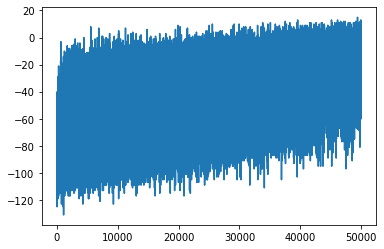

 50%|█████     | 50115/100000 [01:10<01:52, 443.68it/s]

+-----------+-----------+-----------+-----------+------------+----------+----------+
| -14.783   | -14.2708  | -12.8577  |  -9.91089 |  -6.8467   | -6.47991 | -7.23804 |
+-----------+-----------+-----------+-----------+------------+----------+----------+
| -16.3537  | -16.6397  | -15.7912  | -12.1772  |  -9.17777  | -7.27076 | -7.13592 |
+-----------+-----------+-----------+-----------+------------+----------+----------+
| -16.3841  | -18.2962  | -18.3319  | -15.8914  | -11.5072   | -8.09105 | -6.49133 |
+-----------+-----------+-----------+-----------+------------+----------+----------+
| -13.1045  | -14.9643  | -16.3317  | -16.3862  | -11.9751   | -7.9066  | -5.60757 |
+-----------+-----------+-----------+-----------+------------+----------+----------+
|  -8.44966 | -10.9654  | -14.6431  | -14.8822  |  -9.70714  | -4.71021 | -1.22699 |
+-----------+-----------+-----------+-----------+------------+----------+----------+
|  -7.49854 |  -8.0784  |  -8.69202 |  -7.66775 |  -3.84318  |  0

 60%|█████▉    | 59932/100000 [01:19<00:33, 1186.28it/s]

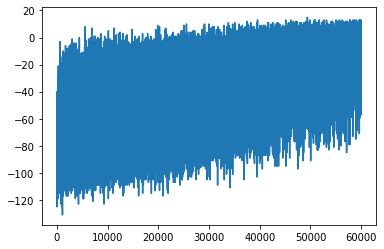

 60%|██████    | 60148/100000 [01:20<01:01, 650.76it/s] 

+-----------+-----------+-----------+-----------+-----------+----------+-----------+
| -11.5861  | -11.0212  |  -9.8089  |  -6.81127 |  -3.81262 | -4.03906 | -4.77352  |
+-----------+-----------+-----------+-----------+-----------+----------+-----------+
| -13.7443  | -13.8767  | -12.9869  |  -9.81946 |  -6.37849 | -4.9641  | -4.71868  |
+-----------+-----------+-----------+-----------+-----------+----------+-----------+
| -14.7696  | -16.8561  | -16.8356  | -14.1463  |  -9.21287 | -5.74769 | -4.14531  |
+-----------+-----------+-----------+-----------+-----------+----------+-----------+
| -10.4472  | -13.2536  | -15.2867  | -15.1944  | -10.4306  | -5.84724 | -3.41853  |
+-----------+-----------+-----------+-----------+-----------+----------+-----------+
|  -5.77333 |  -9.03576 | -13.9061  | -14.3701  |  -8.64773 | -2.74475 |  0.387167 |
+-----------+-----------+-----------+-----------+-----------+----------+-----------+
|  -5.26515 |  -5.96419 |  -7.57477 |  -6.17244 |  -1.92417 |  1.

 70%|██████▉   | 69888/100000 [01:27<00:22, 1363.03it/s]

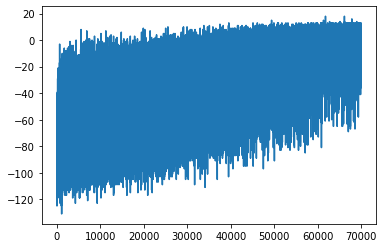

 70%|███████   | 70130/100000 [01:28<00:40, 729.38it/s] 

+-----------+-----------+-----------+------------+----------+----------+----------+
|  -8.84002 |  -8.22735 |  -6.96962 |  -4.35009  | -1.75866 | -1.75549 | -2.80031 |
+-----------+-----------+-----------+------------+----------+----------+----------+
| -11.7402  | -12.0377  | -10.8778  |  -7.63111  | -3.81563 | -2.75378 | -2.87284 |
+-----------+-----------+-----------+------------+----------+----------+----------+
| -13.6304  | -15.9243  | -15.8399  | -13.4181   | -7.68013 | -3.97441 | -2.61822 |
+-----------+-----------+-----------+------------+----------+----------+----------+
|  -8.69859 | -11.992   | -14.4492  | -14.8913   | -9.39634 | -4.23011 | -1.58918 |
+-----------+-----------+-----------+------------+----------+----------+----------+
|  -3.87262 |  -7.69316 | -13.4667  | -14.2609   | -8.14813 | -1.63199 |  2.02635 |
+-----------+-----------+-----------+------------+----------+----------+----------+
|  -3.81136 |  -4.3467  |  -6.67746 |  -5.43541  | -1.2637  |  2.702   |  5.

 80%|███████▉  | 79982/100000 [01:35<00:12, 1553.67it/s]

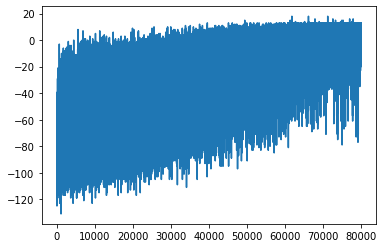

 80%|████████  | 80263/100000 [01:35<00:23, 822.75it/s] 

+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|  -6.90902 |  -6.30463 |  -4.95049 |  -2.7081   | -0.582256 | -0.659859 | -1.62643  |
+-----------+-----------+-----------+------------+-----------+-----------+-----------+
| -10.2561  | -10.4001  |  -9.52294 |  -6.20396  | -2.53205  | -1.33144  | -1.62245  |
+-----------+-----------+-----------+------------+-----------+-----------+-----------+
| -12.7649  | -15.2725  | -15.4911  | -12.9912   | -6.85759  | -2.61058  | -1.24271  |
+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|  -7.24651 | -11.5817  | -13.8584  | -14.6058   | -8.83774  | -3.28406  | -0.292055 |
+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|  -2.48765 |  -7.09069 | -13.304   | -14.0408   | -7.92512  | -0.781364 |  2.77056  |
+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|  -2.5015  |  -3.32147 |  -6.27077 |  -5.1

 90%|████████▉ | 89961/100000 [01:43<00:08, 1214.88it/s]

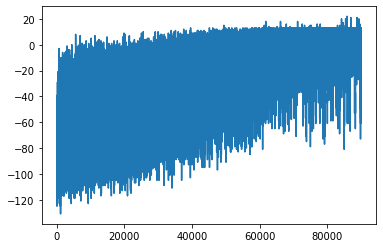

 90%|█████████ | 90237/100000 [01:44<00:20, 475.46it/s] 

+-----------+-----------+-----------+------------+-----------+------------+------------+
|  -4.81022 |  -4.32295 |  -3.1936  |  -1.12275  |  0.867322 |  0.519595  | -0.704399  |
+-----------+-----------+-----------+------------+-----------+------------+------------+
|  -8.6782  |  -9.09106 |  -8.37869 |  -5.36041  | -1.56351  | -0.0683598 | -0.133415  |
+-----------+-----------+-----------+------------+-----------+------------+------------+
| -12.4757  | -15.0637  | -15.0724  | -12.7719   | -6.37894  | -1.68923   | -0.0398624 |
+-----------+-----------+-----------+------------+-----------+------------+------------+
|  -5.8932  | -11.3803  | -13.602   | -14.5437   | -8.68561  | -2.48709   |  1.03651   |
+-----------+-----------+-----------+------------+-----------+------------+------------+
|  -1.46064 |  -6.74924 | -13.3026  | -14.0218   | -7.94334  | -0.366775  |  3.72984   |
+-----------+-----------+-----------+------------+-----------+------------+------------+
|  -1.66053 |  -2.549

100%|██████████| 100000/100000 [01:51<00:00, 895.66it/s]


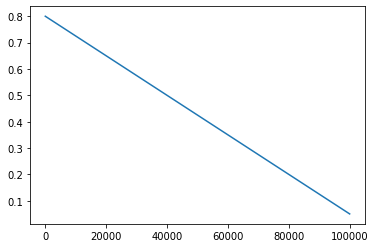

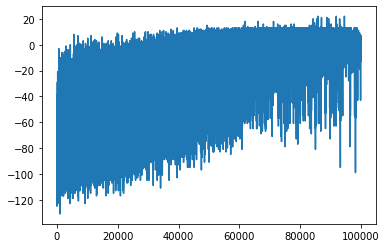

In [20]:
class QLearningAgent:
    def __init__(self, env, epsilon=0.6, alpha=0.1, gamma=0.99, total_iter=1000, verbose=100, min_eps=0.1, schedule_epsilon=False, mode='ql'):
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_eps = epsilon
        self.alpha = alpha
        self.min_eps = min_eps
        self.qvals = [[0 for _ in range(self.n_actions)] for _ in range(self.n_states)]
        self.env = env
        self.total_iter = total_iter
        self.returns = []
        self.epsilons = []
        self.verbose = verbose
        self.schedule_epsilon = schedule_epsilon
        self.mode = mode
        
    def get_action(self, state, deterministic=False):
        if deterministic:
            return np.argmax(self.qvals[state])
        best_actions = []
        max_q = max(self.qvals[state])
        for idx, qval in enumerate(self.qvals[state]):
            if qval == max_q:
                best_actions.append(idx)
        if random() <= self.epsilon:
            #random action
            return randint(0, self.n_actions-1)
        #choose one of the best actions
        return choice(best_actions)
            

    def sample_trajectory(self):
        traj_states = []
        traj_actions = []
        traj_rewards = []
        
        done = False
        state = self.env.reset()
        
        while not done:
            traj_states.append(state)
            action = self.get_action(state)
            traj_actions.append(action)
            state, reward, done, _ = self.env.step(action)
            traj_rewards.append(reward)
            
            if done:
                traj_states.append(state)
            
        
        return traj_states, traj_actions, traj_rewards
    
    def update_qvals(self, traj_states, traj_actions, traj_rewards):
        for i in reversed(range(len(traj_states[:-1]))):
            state, action, reward, next_state = traj_states[i], traj_actions[i], traj_rewards[i], traj_states[i+1]
            if self.mode == 'ql':
                self.qvals[state][action] += self.alpha * (reward + self.gamma*max(self.qvals[next_state]) - self.qvals[state][action])
            elif self.mode == 'sarsa':
                next_action = self.get_action(next_state)
                self.qvals[state][action] += self.alpha * (reward + self.gamma*self.qvals[next_state][next_action] - self.qvals[state][action])
    
    def solve(self):
        for i in tqdm(range(self.total_iter)):
            self.epsilons.append(self.epsilon)
            
            self.epsilon = self.min_eps + (self.max_eps-self.min_eps)*max(0, (self.total_iter-i)/self.total_iter)
                
            if self.verbose and i%self.verbose==0:
                plt.plot(self.returns)
                plt.show()
                print(tabulate(np.mean(self.qvals, axis=-1).reshape((7, 7)), headers=[], tablefmt='grid'))
                print()
                
            traj_states, traj_actions, traj_rewards = self.sample_trajectory()
            episode_return = sum(traj_rewards)
            self.returns.append(episode_return)
            self.update_qvals(traj_states, traj_actions, traj_rewards)
            
        plt.plot(self.epsilons)
        plt.show()
        plt.plot(self.returns)
        plt.show()
    
    
env = GoldHuntEnv(ascii_rep=False)
agent = QLearningAgent(env, total_iter=100000, verbose=10000, epsilon=0.8, min_eps=0.05, alpha=0.03, gamma=0.95, schedule_epsilon=True, mode='sarsa')
agent.solve()

## show an episode

{'cum_r': -5, 'action': 'agent performed Action.DOWN', 'status': 'agent found the GOLD!', 'step': 11, 'statu': ''}


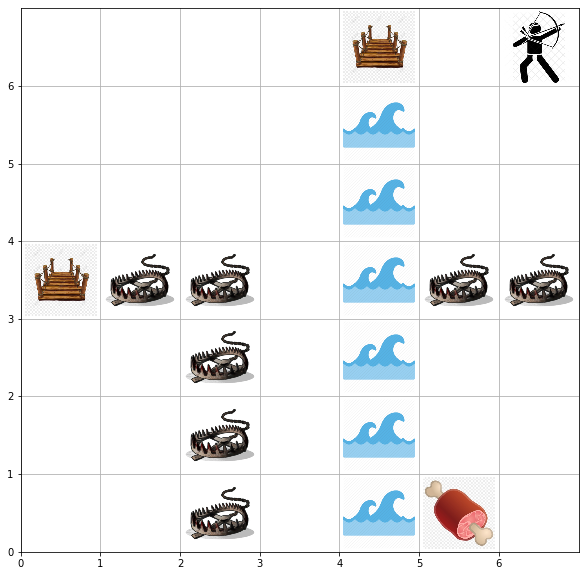

In [21]:

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        
        action = agent.get_action(state, deterministic=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        
env = GoldHuntEnv(ascii_rep=False)
play(env, agent)